In [2]:
import sched, time
import requests
import json

from scipy import optimize
import numpy as np
import pandas as pd

from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import seaborn as sns

import gmplot

# downloading the data

Create class to dowload data from url, using an api key.

In [16]:
class download_data(object):
    """
    class to download data at periodic time intervals
    """
    
    data_list = []
    
    def __init__(self, url, api_key, delta_t=1800, total_t=1800):
        """
        returns a download object whose attributes are the url of
        the website, the api key to download the data, the periodicity
        of the download cycle and the total time to perform this task for
        """
        self.url = url
        self.api_key = api_key
        self.delta_t = delta_t
        self.total_t = total_t
        # initialize a list for downloaded data to be stored in
        
    def run(self):
        """
        runs download task for specified time period and periodicity
        from website with given api key
        """
        
        def download():
            """
            function which downloads data from url, url, with api key, api_key
            """
            # set the request parameters
            my_url = self.url + '&apiKey=' + self.api_key
            user = 'admin'
            pwd = 'admin'

            # set proper headers
            headers = {"Accept":"application/json"}
 
            # perform the HTTP request
            response = requests.get(my_url, auth=(user, pwd), headers=headers)
 
            # append downloaded json data to data_list
            self.data_list.append(response.json())
            
        def comment():
            """
            comment function
            """
            print(time.monotonic(), 'step complete')
            
        def save_as_csv(filepath):
            """
            saves data as csv file
            """
        
        # initialize scheduler
        sch = sched.scheduler()
        # truncate number of time intervals to integer
        time_period = self.delta_t
        no_time_intervals = int(self.total_t / self.delta_t) 
        # execute download at given time periods in total time
        time_list = [t * time_period for t in range(no_time_intervals + 1)]
        for time_stamp in time_list:
            sch.enter(time_stamp, 1, comment)
            sch.enter(time_stamp, 2, download)
            
        # run scheduled tasks
        sch.run()

Run the task.

In [17]:
dd = download_data('https://api.jcdecaux.com/vls/v1/stations?contract=Dublin', 
                     'd2aa5a02f507f8ed4aad52a78772c1496c7cb505', 60*10, 60*10*5)
dd.run()

54201.5 step complete
54801.5 step complete
55401.5 step complete
56001.5 step complete
56601.5 step complete
57201.5 step complete


Save the data.

In [31]:
with open('data.json', 'w') as outfile:
    json.dump(dd.data_list, outfile)

# loading the data 

In [32]:
with open('data.json', 'r') as infile:
    data = json.load(infile)

# displaying the data on a map

In [33]:
bike_list0, bike_list1 = [], []
long_list, lat_list = [], []
length = len(data[0])

# define list of available bikes at each station
for n in range(length):
    bike_list0.append(data[0][n]['available_bikes'])
    bike_list1.append(data[-1][n]['available_bikes'])
    # define list of longitudes and latitudes of stations
    long_list.append(data[0][n]['position']['lng'])
    lat_list.append(data[0][n]['position']['lat'])

### cluster stations

We now cluster the stations. We do this to improve the running time of the algorithm, which is otherwise very computationally intensive.

Display geographical location of stations.

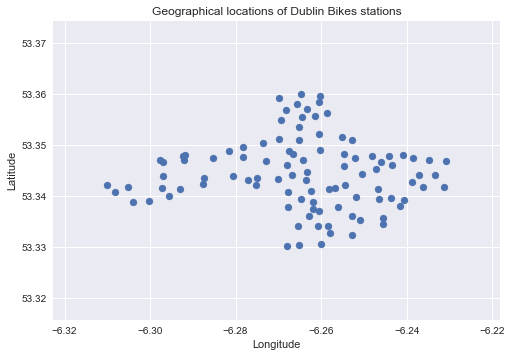

In [158]:
sns.set_style()
plt.scatter(long_list, lat_list)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Geographical locations of Dublin Bikes stations')
plt.show()

We now use KMeans to group the stations according to their geographical location.

We also produce a html output of the data displayed over Google maps below.

In [157]:
# center plot
gmap = gmplot.GoogleMapPlotter(53.345, -6.276, 14)
# for some reason can't get scatter to work
gmap.heatmap(lat_list, long_list)
# draw map
gmap.draw("dublin_bikes_map.html")

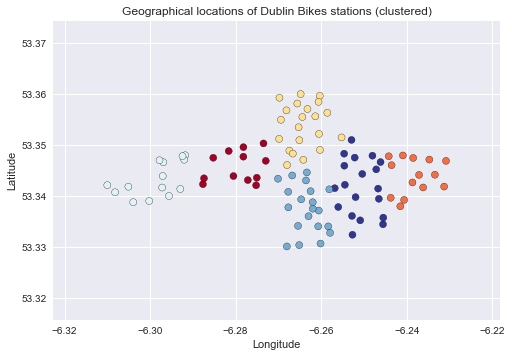

In [159]:
# define an array of longitudes and latitudes
X = np.array([x for x in zip(long_list, lat_list)])

kmeans = KMeans(n_clusters=6, random_state=42).fit(X)

# plot with labels
cm = plt.cm.get_cmap('RdYlBu')
plt.scatter(long_list, lat_list, c=kmeans.labels_, cmap=cm, edgecolors='black')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Geographical locations of Dublin Bikes stations (clustered)')
plt.show()

# analyzing the data

## inferring routes via a loss function

#### aggregate data

We now aggregate the data according to the clustering.

In [102]:
bike_station_df = pd.DataFrame([x for x in zip(bike_list0, bike_list1, kmeans.labels_)])
bike_station_df.columns = ['t0', 't1', 'cluster']
bike_station_df.head()

,t0,t1,cluster
0,27,18,0
1,3,4,2
2,2,0,5
3,1,0,1
4,0,0,5


Aggregate.

In [103]:
bike_cluster_df = bike_station_df.groupby('cluster').sum()

In [104]:
bike_cluster_df['pc_t0'] = bike_cluster_df.t0 / bike_cluster_df.t0.sum()
bike_cluster_df['pc_t1'] = bike_cluster_df.t1 / bike_cluster_df.t1.sum()

In [105]:
bike_cluster_df

,t0,t1,pc_t0,pc_t1
cluster,,,,
0,303,299,0.225446,0.221810
1,141,138,0.104911,0.102374
2,275,287,0.204613,0.212908
3,385,401,0.286458,0.297478
4,132,116,0.098214,0.086053
5,108,107,0.080357,0.079377


### initialize

In [106]:
# define initial and final vectors
xf = bike_cluster_df.t1
xi = bike_cluster_df.t0
# store length of the (two) list(s)
n = bike_cluster_df.shape[0]
# initialize random probabilties
p0 = np.random.rand(n, n)
p0_rshp = p0.reshape(-1)

In [107]:
def loss_fxn(p_fi):
    """
    gives loss function for given probability matrix,
    initial and final vectors
    """
    p_fi_reshaped = p_fi.reshape(n, n)
    loss = np.sum((xf - np.dot(xi, p_fi_reshaped))**2)
    return loss

In [108]:
def fun_constr0(p0_rshp_var):
    p0_tmp = p0_rshp_var.reshape(n,n)
    return np.linalg.norm(1 - np.sum(p0_tmp, axis=0))

def fun_constr1(p0_rshp_var):
    p0_tmp = p0_rshp_var.reshape(n,n)
    return np.linalg.norm(1 - np.sum(p0_tmp, axis=1))

def fun_constr2(p0_rshp_var):
    p0_tmp = p0_rshp_var.reshape(n,n)
    return np.linalg.norm(np.sum(p0_tmp, axis=0) - np.sum(p0_tmp, axis=1))

Make symmetric

In [109]:
# impose constraints on the probabilities
cons = ({'type': 'eq', 'fun': fun_constr0}, {'type': 'eq', 'fun': fun_constr2})

# test loss function
print(loss_fxn(p0_rshp))

# define bounds on each entry in the probability matrix
bnd = (0, 1)
bnd_array = tuple([bnd for n in range(n**2)])

# minimize the loss function
opt = optimize.minimize(loss_fxn, p0_rshp, method='SLSQP', bounds=bnd_array, constraints=cons)
# reshape the data
opt_rshp = opt.x.reshape(n, n)
print(np.sum(opt_rshp, axis=1), np.sum(opt_rshp, axis=0)) 
print(opt_rshp.round(4))

1608454.4905987834
[ 0.99993849  0.99993173  0.99985769  1.0002304   0.99996801  1.00011541] [ 1.00000944  0.99999671  1.00000839  1.00004306  0.99999127  0.99999285]
[[  7.14600000e-01   0.00000000e+00   2.85300000e-01   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   9.99700000e-01   0.00000000e+00   0.00000000e+00
    1.00000000e-04   1.00000000e-04]
 [  2.85400000e-01   0.00000000e+00   7.14500000e-01   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  1.00000000e-04   0.00000000e+00   2.00000000e-04   1.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   3.00000000e-04   0.00000000e+00   0.00000000e+00
    6.87700000e-01   3.12000000e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    3.12100000e-01   6.88000000e-01]]


In [110]:
pd.DataFrame(opt_rshp)

,0,1,2,3,4,5
0,7.145701e-01,1.478643e-06,0.285319,4.682558e-05,4.710775e-07,2.348138e-07
1,5.386315e-06,9.997180e-01,0.000031,5.820985e-07,1.179929e-04,5.864629e-05
2,2.853628e-01,9.883156e-06,0.714482,2.321529e-06,1.707035e-07,1.110559e-07
3,6.774930e-05,5.771241e-07,0.000169,9.999924e-01,3.820861e-07,3.203704e-07
4,2.753882e-06,2.609855e-04,0.000005,4.156536e-07,6.877458e-01,3.119527e-01
5,6.424758e-07,5.741310e-06,0.000001,5.129711e-07,3.121264e-01,6.879808e-01


In [111]:
final_df = pd.DataFrame((opt_rshp + opt_rshp.T) / 2)

In [114]:
final_df.round(2)

,0,1,2,3,4,5
0,0.71,0.0,0.29,0.0,0.00,0.00
1,0.00,1.0,0.00,0.0,0.00,0.00
2,0.29,0.0,0.71,0.0,0.00,0.00
3,0.00,0.0,0.00,1.0,0.00,0.00
4,0.00,0.0,0.00,0.0,0.69,0.31
5,0.00,0.0,0.00,0.0,0.31,0.69


In [113]:
print(np.sum(final_df, axis=1))
print('')
print(np.sum(final_df, axis=0))

0    0.999974
1    0.999964
2    0.999933
3    1.000137
4    0.999980
5    1.000054
dtype: float64

0    0.999974
1    0.999964
2    0.999933
3    1.000137
4    0.999980
5    1.000054
dtype: float64


# what I want to do

* put stations on a map
* regularly pull data
* perform time series analysis
* loss function
* comparitive study
* most frequent route